In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

## Get photo ids and create label dictionary 

In [2]:
eng = create_engine('sqlite:///db/data.sqlite3', echo=False)

# get array of all image ids that aren't associated with any blank label 
sql = """
select distinct img_url_hash
from data
where img_url_hash not in 
  (select img_url_hash from data where data_category is '')
"""
res = eng.execute(sql)
ids = np.array([row[0] for row in res.fetchall()])

# get lookup dict for image id -> label
labels = {}
for iid in ids:
    sql = "select data_category from data where img_url_hash = ? and data_category like '%Comics%'"
    rows = eng.execute(sql, (iid, )).fetchall()
    # label 1 if a cartoon appears
    if rows:
        labels.update({iid: 1})
    # label 0 if it doesn't
    else:
        labels.update({iid: 0})


In [3]:
# Check totals against some things we know about data

positive = sum(1 for val in labels.values() if val == 1)
negative = sum(1 for val in labels.values() if val == 0)
print('{} positive, {} negative'.format(positive, negative))

assert negative == 962
assert positive == 130

assert labels['3b01461ac1ab71813b7ec4dd63ee6e59'] == 1
assert labels['02fb7b34ab71235d9d59b34cec6dabe3'] == 0


130 positive, 962 negative


## Create test train and validation datasets

In [4]:
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

base_img_path = 'images/modified/'

def path_to_tensor(img_path, color_mode):
    """Take a path to an image file and return a 4D tensor for Keras"""
    img = image.load_img(img_path, target_size=(299, 299), color_mode=color_mode,
                         interpolation='bicubic')
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 299, 299, number of channels)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, color_mode):
    """Take a list of image file paths and return 4D tensors for Keras"""
    list_of_tensors = [path_to_tensor(img_path, color_mode=color_mode) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

def get_data(ids):
    # split data randomly into test, train and validation datasets
    train_ids, valid_test_ids = train_test_split(ids, test_size=0.25, shuffle=True)
    vt_split = int(len(valid_test_ids) // 2)
    valid_ids = valid_test_ids[:vt_split]
    test_ids = valid_test_ids[vt_split:]

    # get paths to images
    train_paths = [base_img_path + '{}.jpg'.format(id) for id in train_ids]
    valid_paths = [base_img_path + '{}.jpg'.format(id) for id in valid_ids]
    test_paths = [base_img_path + '{}.jpg'.format(id) for id in test_ids]
    
    # get tensors from images
    x_train = paths_to_tensor(train_paths, color_mode='grayscale') / 255
    x_valid = paths_to_tensor(valid_paths, color_mode='grayscale') / 255
    x_test = paths_to_tensor(test_paths, color_mode='grayscale') / 255

    # get labels from label lookup dict
    y_train = np.array([labels[id] for id in train_ids])
    y_valid = np.array([labels[id] for id in valid_ids])
    y_test = np.array([labels[id] for id in test_ids])
    
    return (x_train, y_train), (x_valid, y_valid), (x_test, y_test)

(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = get_data(ids)



/home/appuser/miniconda3/envs/appenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


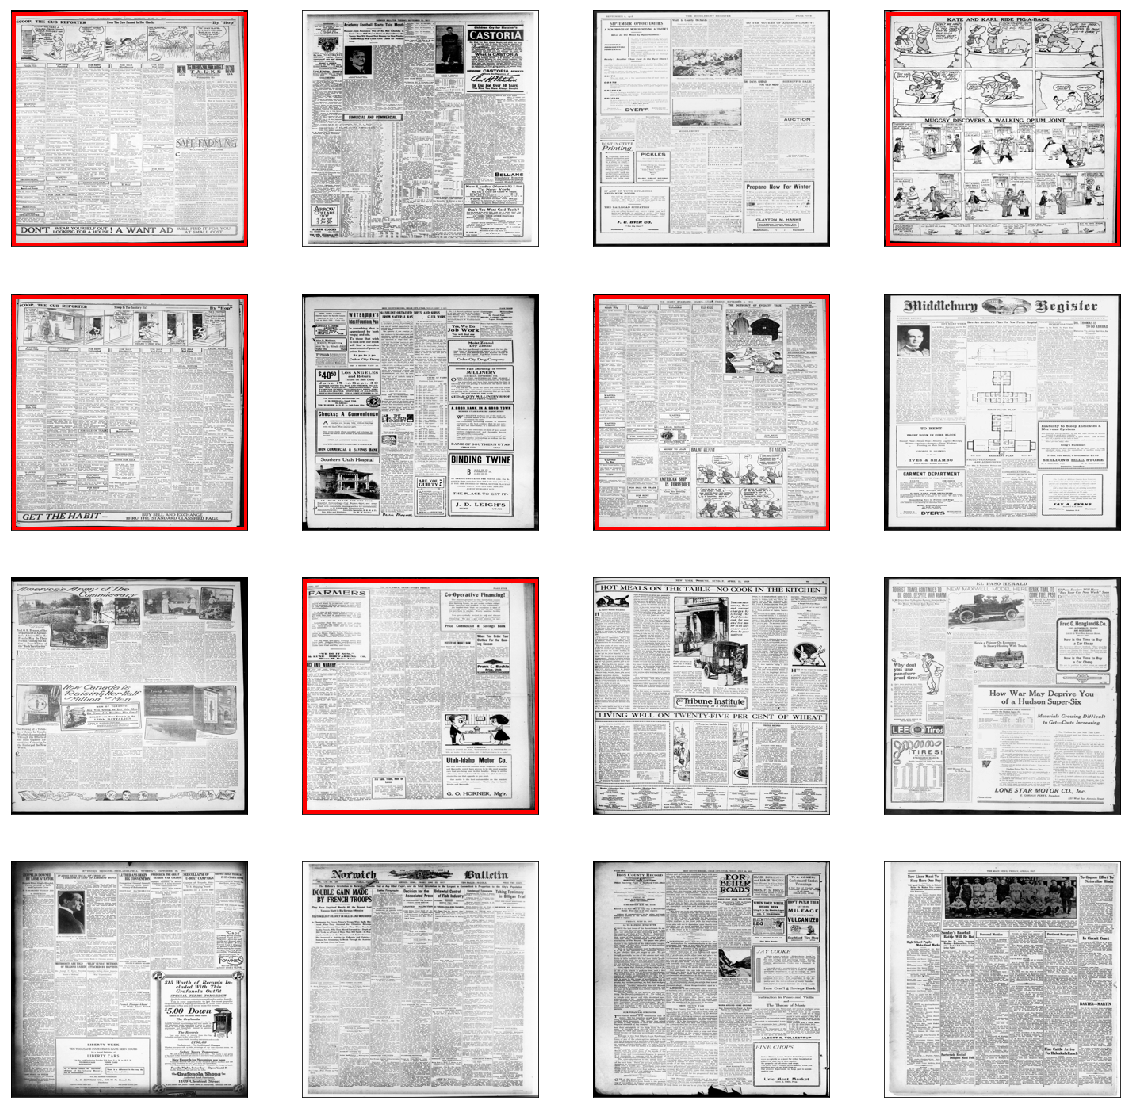

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig = plt.figure(figsize=(20, 20))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]), cmap='gray')
    if y_train[i]:
        rect = patches.Rectangle((4, 4), 293, 293, linewidth=4, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


In [7]:
from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator()

datagen_train.fit(x_train)

In [50]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization

model = Sequential()

# first conv layer
model.add(Conv2D(
    filters=16,
    kernel_size=2,
    padding='same',
    use_bias=False,
    input_shape=(299, 299, 1),
    kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# second conv layer
model.add(Conv2D(filters=32, kernel_size=2, padding='same',
                 use_bias=False, kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# third conv layer
model.add(Conv2D(filters=64, kernel_size=2, padding='same',
                 use_bias=False, kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# dense layer
model.add(Flatten())
model.add(Dense(512, use_bias=False, kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# output layer
model.add(Dense(1, use_bias=False, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 299, 299, 16)      64        
_________________________________________________________________
activation_21 (Activation)   (None, 299, 299, 16)      0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 299, 299, 16)      64        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 149, 149, 32)      2048      
_________________________________________________________________
activation_22 (Activation)   (None, 149, 149, 32)      0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 149, 149, 32)      128       
__________

In [51]:
# compile the model
model.compile(
    loss='binary_crossentropy', #loss='categorical_crossentropy',
    optimizer='adam', 
    metrics=['accuracy']
)

In [52]:
from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 15

checkpointer = ModelCheckpoint(
    filepath='aug_model.weights.best.hdf5',
    verbose=1,
    save_best_only=True
)

model.fit_generator(
    datagen_train.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=2,
    callbacks=[checkpointer],
    validation_data=(x_valid, y_valid),
    validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/15
 - 7s - loss: 0.7997 - acc: 0.6065 - val_loss: 1.9944 - val_acc: 0.7426

Epoch 00001: val_loss improved from inf to 1.99438, saving model to aug_model.weights.best.hdf5
Epoch 2/15
 - 3s - loss: 0.4257 - acc: 0.8266 - val_loss: 12.1226 - val_acc: 0.1397

Epoch 00002: val_loss did not improve from 1.99438
Epoch 3/15
 - 3s - loss: 0.2710 - acc: 0.9083 - val_loss: 11.4351 - val_acc: 0.1397

Epoch 00003: val_loss did not improve from 1.99438
Epoch 4/15
 - 3s - loss: 0.1618 - acc: 0.9604 - val_loss: 12.6488 - val_acc: 0.1838

Epoch 00004: val_loss did not improve from 1.99438
Epoch 5/15
 - 3s - loss: 0.0852 - acc: 0.9937 - val_loss: 13.2430 - val_acc: 0.1691

Epoch 00005: val_loss did not improve from 1.99438
Epoch 6/15


KeyboardInterrupt: 

In [48]:
# load the weights with the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

# get test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8613138699183499
